# StationSim Validation

The aim of this notebook is to establish whether the outputs of two different versions of our agent based model (ABM) StationSim in python and c++ produce the same output. Since our model is by nature highly stochastic and non-linear it is difficult to do this without seeding each model. 

We generate two populations of StationSim models without any seeding and test statistically if there is any evidence the two groups produce distinct results. 

## Initialisation

Make sure all imports work before running this notebook further.


In [1]:
import sys
import os
import numpy as np
from shutil import rmtree

# Import the stationsim model
sys.path.append("..")
from stationsim_model import Model #python version of stationsim from stationsim_validation import stationsim_RipleysK

# For running the Ripley's K analysis later
from stationsim_validation import stationsim_RipleysK, collision_Folder_Name
from stationsim_validation import save_Collision_csvs, load_Collision_csvs
ssRK = stationsim_RipleysK() # 

## Building a Population of StationSim Models

First we define the StationSim model we wish to test. StationSim requires a dictionary of input parameters which we define below. We are particularly interested in the model width, height, population total, and rate at which agents enter model `gates_speed`.

Using these parameters we run a set of models using `ssRK.generate_model_sample`. The size of the sample is determined by `n_test_runs`. We currently are only getting 1 model per batch for plotting purposes. Note we are seeding this time using the `random_seed` arguement for demonstrative purposes. We will not seed any runs outside of this notebook.

In [2]:
model_params = {
'width': 200,
'height': 50,
'pop_total': 10,
'gates_speed': 1,


'gates_in': 3,
'gates_out': 2,
'gates_space': 1,

'speed_min': .2,
'speed_mean': 1,
'speed_std': 1,
'speed_steps': 3,

'separation': 5,
'max_wiggle': 1,

'step_limit': 3600,

'do_history': True,
'do_print': True,
    
'random_seed' : 8,
}

n_test_runs = 1

model1 = ssRK.generate_Model_Sample(n_test_runs, model_params)
model_params["random_seed"] = 2 #change seed
model2 = ssRK.generate_Model_Sample(n_test_runs, model_params)

model1_collisions = [np.vstack(model.history_collision_locs) for model in model1] 
model2_collisions = [np.vstack(model.history_collision_locs) for model in model2] 

## Fundamental statistics

TODO 

_Here I would just compare just the basic things: time taken for all agents to leave the simulation, total number of collisions, etc._

In [3]:
print(model1[0].get_analytics())
print(f"Total Number of Collisions: {len(model1_collisions[0])}")
print(model2[0].get_analytics())
print(f"Total Number of Collisions: {len(model2_collisions[0])}")

{'Finish Time': 641, 'Total': 10, 'Active': 0, 'Finished': 10, 'Mean Time Taken': 282.3, 'Mean Time Expected': 257.9321905814454, 'Mean Time Delay': 24.367809418554558, 'Mean Collisions': 48.4, 'Mean Wiggles': 4.7}
Total Number of Collisions: 484
{'Finish Time': 801, 'Total': 10, 'Active': 0, 'Finished': 10, 'Mean Time Taken': 258.4, 'Mean Time Expected': 254.4976921599207, 'Mean Time Delay': 3.9023078400793105, 'Mean Collisions': 12.5, 'Mean Wiggles': 3.3}
Total Number of Collisions: 125


## Clustering Overview

We can easily plot where the collisions happen in a model using a kernel density estimate (KDE). We have chosen a low number of agents (10) to demonstrate the extreme cases of how collisions can vary.

For our first model we notice most of the collisions occur in a straight line fashion across the map. This demonstrates a clear sign of queueing where some agent(s) are stuck behind and constantly colliding with a slower agent. Note we also have very few collisions near the entrance gates, suggesting all agents enter at different times with little difficulty.

Our second plot shows three large groups of collisions near the entrance gates. It is clear that all our agents enter the model at a similar time causing large initial crowding. As time progesses the agents break away and proceed unhindered with no futher collisions.

We have the two extreme cases of collision clustering here. The first case shows collisions that are quite widely dispersed across the map whereas the second model has very tightly clustered collisions.

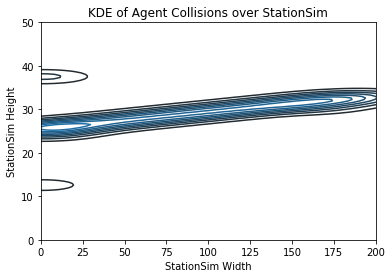

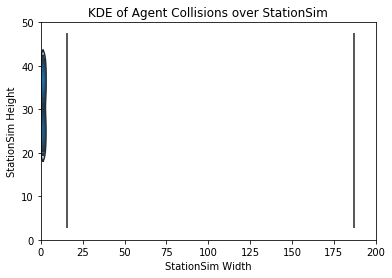

In [4]:
width = model_params["width"]
height = model_params["height"]
ssRK.collisions_kde(model1_collisions[0], width, height)
ssRK.collisions_kde(model2_collisions[0], width, height)

With larger numbes of agents, however, the cluster locations tend to become more similar. The following plots show the behaviour of two models with different random seeds and 80 agents.

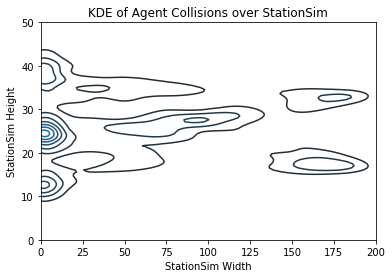

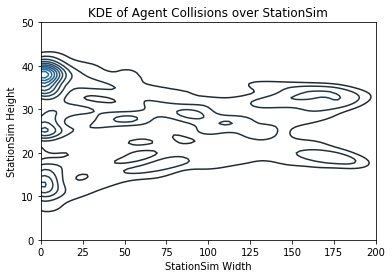

In [5]:
model_params['pop_total']= 80

model_params['random_seed'] = 10
model1a = ssRK.generate_Model_Sample(n_test_runs, model_params)
model1a_collisions = [np.vstack(model.history_collision_locs) for model in model1a] 
ssRK.collisions_kde(model1a_collisions[0], width, height)

model_params["random_seed"] = 11
model2a = ssRK.generate_Model_Sample(n_test_runs, model_params)
model2a_collisions = [np.vstack(model.history_collision_locs) for model in model2a] 
ssRK.collisions_kde(model2a_collisions[0], width, height)

## Validation Using Ripley's K

In this section we analyse the spatial locations of collisions and compare their average distances -- a second-order property -- using a statistic called _Ripley's K_.

We do this by analysing the `collision_history_loc` attribute for each stationsim instance telling us where any collisions between two agents occured in the model. We calculate the Ripley's K (RK) trajectories for each set of collisions giving two samples of RK curves.

Using these two populations of curves, we fit a panel regression in R. and test if there is a different between the two groups using a panel regression and ANOVA.

This notebook will demonstrate how we calculate RK curves from a set of models and compile them into a dataframe to be used in R.

Ripley's K is used as a measure of how dispersed some set of points is throughout a region of interest. I refer the 
reader to the more detailed link below.
 
(https://wiki.landscapetoolbox.org/doku.php/spatial_analysis_methods:ripley_s_k_and_pair_correlation_function)

We can visualise the distribution of collisions using Ripley's K curves. Generally, if our agents are tightly clustered tightly we see a rapid increase in RK score that quickly plateaus. Conversely, if our collisions are spread out we see a slow linear increase in the RK score.

We plot RK curves for the clustered and dispersed models below clearly seeing these characteristics. We expect an envelope* such that almost all RK curves lie within these extremes.

(*The theoretical maximum RK score is a vertical line from (0,0) where all collisions occur at exactly the same point. The minimum score would be a straight line where all collisions are equally dispersed. Both these theoretical extremes are impossible in practice and make poor bounds so I use this much narrower boundary where there is a strong chance for outliers.)

### Collisions data format

To compare the results of the python model with others (e.g. `stationsimcpp`) then data on the locations of the collisions needs to be read from both. In the python implementation the data are stored in the `model.collision_history_loc` attribute so can be read directly. Other implementations will need to output these collisions as CSV files.

_XXXX - Here we need to document how other programs should output information about the collisions so that it can be read in by this workbook and used to compare. E.g.: filenames, columns, etc..._

For a single model we store collisions in a csv with two columns. Each column represents the x and y coordinates of collisions such that a single row represents the coordinates of a single collision. 

For multiple runs, we first create a subfolder with a unique name. This name consists of the source, parameter, and unique id components. The source indicates whether are collisions are from the python or cpp stationsim model. We may also include some other prefixes such as `test_` or a destination file to save the folder in e.g. `RK_csvs/`.  The parameter component provides a list of important stationsim parameters such as the width, height, population total, and entry speed. This is mainly for identification and gets useful if you have a lot of control data. Finally, we have a unique identifier allowing us to repeat multiple tests with the same parameters to be stored in different files. We use the time form python's `datetime.datetime.now()`.

We then save multiple runs inside this subfolder. Each single has a csv of collisions as described above with simple names corresponding to intigers 0.csv, 1.csv, 2.csv, ... See `save_Collision_csvs` in `stationsim_validation.py` for an example of how to save python collisions as csvs.

To retreive these files we use `load_Collision_csvs` also in `stationsim_validation.py`. This function only loads csvs so should be able to use collisions from any source given they have the correct structure.

Here we have an example of saving and loading using `model1`'s collisions.

In [6]:
width = model_params["width"]
height = model_params["height"]
pop_total = model_params["pop_total"]
gates_speed = model_params["gates_speed"]
parameters = [width, height, pop_total, gates_speed]
folder_name = collision_Folder_Name("RK_csvs/test_python", parameters)
print(f"saving to: {folder_name}")

#SAVING REQUIRES A LIST OF MODELS. CANT BE ONE SINGLE MODEL

test_collisions = [model.history_collision_locs for model in model1] 
save_Collision_csvs(test_collisions, folder_name)

saving to: RK_csvs/test_python_200_50_80_1_2020_03_09_15_21_03


In [7]:
new_collisions = load_Collision_csvs(folder_name)

#(almost) 0 if arrays the same
print(np.sum(test_collisions[0][:5] - new_collisions[0][:5]))
"remove test folder for tidiness omit this if you want to see the full folder"
rmtree(folder_name)

7.022160630754115e-15


For info, here is what the data in the `history_collision_locs` look like:

In [8]:
#  Make a model with a few more agents so that there are a reasonable number of  collisions
model_params['pop_total']= 80
model_params["random_seed"] = 1
model3 = ssRK.run_model(model_params)
collisions = model3.history_collision_locs # list of [x,y] arrays (one item for each colision)
print("First ten collision locations:")
for x in collisions[:10]:# print first 10 items
    print (x)
print ("...")

	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
	Iteration: 400/3600
	Iteration: 500/3600
	Iteration: 600/3600
	Iteration: 700/3600
	Iteration: 800/3600
	Iteration: 900/3600
	Iteration: 1000/3600
StationSim None - Everyone made it!
First ten collision locations:
[ 1.53334647 38.21854205]
[ 1.26676055 38.225104  ]
[ 1.00017463 38.23166595]
[ 0.73358871 38.2382279 ]
[ 0.46700279 38.24478985]
[ 0.20041687 38.25135179]
[ 0.32708052 36.89012855]
[ 0.87192629 25.04018409]
[ 0.60549508 25.05138777]
[ 0.33906387 25.06259144]
...


In [9]:
len(model1_collisions)

1

### Ripley's K for Python StationSim

Now generate some data using the python implementation and do the Ripley's K analysis.

100.0% complete                  

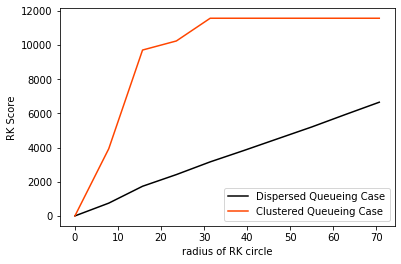

In [10]:
RKs1 = ssRK.generate_Test_Frame(model1_collisions, width, height)
RKs2 = ssRK.generate_Test_Frame(model2_collisions, width, height)
ssRK.notebook_RK_Plot(RKs1,RKs2)

To demonstrate this further we generate an unseeded larger sample of 100 StationSims with 10 agents to see the spread of these curves. It is clear the linear lower bound is much more defined than the upper bound.

100.0% complete                               

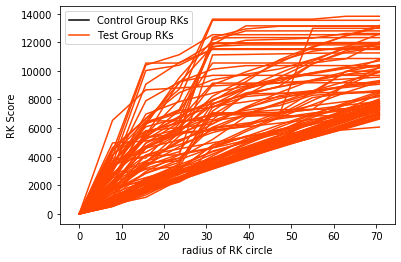

In [19]:
model_params["random_seed"] = None
model_params["pop_total"] = 10
n_test_runs = 100
models = ssRK.generate_Model_Sample(n_test_runs, model_params)
collisions = [np.vstack(model.history_collision_locs) for model in models] 
RKs = ssRK.generate_Test_Frame(collisions, width, height)
ssRK.spaghetti_RK_Plot(RKs)

Until now we have used a small number of agents (10) per model run. If we increase this we see the envelope of RK curves collapses quite dramatically. We get very few clustered cases as with `model2` above as the number and spread of collisions increases. We see that the results become much more uniform regardless of seeding.

100.0% complete                  

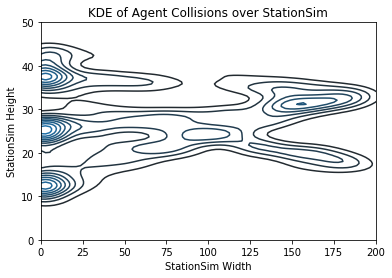

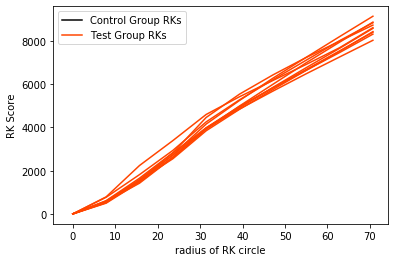

In [21]:
model_params["pop_total"] = 50
n_test_runs = 10
models = ssRK.generate_Model_Sample(n_test_runs, model_params)
collisions = [np.vstack(model.history_collision_locs) for model in models] 

ssRK.collisions_kde(collisions[0], width, height)
RKs = ssRK.generate_Test_Frame(collisions, width, height)
ssRK.spaghetti_RK_Plot(RKs)

In [22]:
# Clear a bit of memory
del(models)

## Testing Two Groups of StationSim Models

We have now defined the behaviour of RK curves on StationSim. We now present how we use these curves for testing. I will talk through the `main` file of `stationsim_RipleysK` and how it constructs a data frame ready for analysis in R. 

The function is broken into two parts, generating the control and test frames respectively. The first section generates the control frame. This generates a population of stationsim models from the python version, calculates the corresponding family of RK curves, and saves these curves in a pandas DataFrame.

First we generate a file name based on the given stationsim parameters. We look to see if control data already exists in the `RK_csvs` folder and if it does not, we generate a control group using 100 stationsim models with the provided parameters. This can take a long time for large ABM populations.
```
width = model_params["width"]
height = model_params["height"]
pop_total = model_params["pop_total"]
gates_speed = model_params["gates_speed"]

f_name = "RK_csvs/control_" + f"{width}_{height}_{pop_total}_{gates_speed}" + ".csv"

"try loading said file. if no file make and save one."
try:
    data_control = self.load_Frame(f_name)
    print("Control data found at: " + f_name)
except:
    print("No control frame found for given parameters.")
    print("Generating control frame using large number of models (100).")
    print("This may take a while if you have a large population of agents")
    control_models = ssRK.generate_model_sample(100, model_params)
    data_control = self.generate_Control_Frame(control_models)~~
    
```

The second section of the main function generates a test data frame. This takes models `test_models` from some new source, such as c++ stationsim, calculate the RK curves, and creates a dataframe for the test RK curves.

```
data_test = self.generate_Test_Frame(test_models)
```

Finally we concatenate the control and test group frames together and save this as a .csv for analysis by R.

```
data = pd.concat([data_control, data_test])
f_name = "RK_csvs/joint_" + f"{width}_{height}_{pop_total}_{gates_speed}"
f_name += ".csv"
self.save_Frame(data, f_name)
```

We provide an example usage where we have a test group of 50 python stationsim models each with a population of 30. We also provide another spaghetti plot using two groups this time for comparison.

Control data found at: RK_csvs/control_200_50_30_1.csv
100.0% complete                               

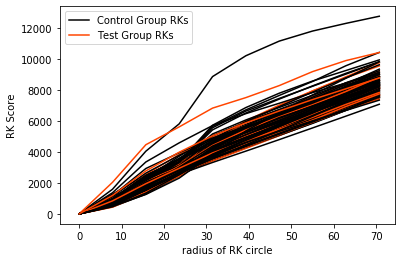

In [27]:
model_params = {
    'width': 200,
    'height': 50,
    'pop_total': 30,
    'gates_speed': 1,
    'random_seed': None,

    'gates_in': 3,
    'gates_out': 2,
    'gates_space': 1,

    'speed_min': .2,
    'speed_mean': 1,
    'speed_std': 1,
    'speed_steps': 3,

    'separation': 5,
    'max_wiggle': 1,

    'step_limit': 3600,

    'do_history': True,
    'do_print': True,
}

n_test_runs = 30
test_models = ssRK.generate_Model_Sample(n_test_runs, model_params)
test_collisions = [model.history_collision_locs for model in test_models] 
data = ssRK.main(test_collisions, model_params)
ssRK.spaghetti_RK_Plot(data)

## RK Curve Panel Regression Analysis for StationSim

Given two groups of Ripley's K curves we wish to determine if the two groups are statistically distinct. We do this using panel regression on a linear mixed model using R's `nlme` package. The source code is contained in `RK_population_modelling.R`.

The test works as follows:

1. We fit 8 models in total ranging starting with the fully saturated linear mixed model `mmod123` assuming there is indeed separation between the two groups. We model the Ripley's K value `y` for a given radius `x` for the number of groups $i = 1, 2$ and number of models per group $j = 1,...,n_i$ as follows.

$$ mmod123 = y_{ij} = (\alpha_0 + \beta_0 + \color{red}{\gamma_{0}}) + (\alpha_1 + \beta_1 + \color{red}{\gamma_1})x_{ij} + (\beta_2 + \color{red}{\gamma_2})x^2_{ij} + \varepsilon_{ij} $$

Where $\alpha_i \sim N_3(0, \Sigma_{\alpha})$ are normal distributed random effects, $\beta_i$ are fixed effects, $\gamma_i$ are level effects (or factor effects etc.), and $\varepsilon_{ij} \sim N(0, \sigma_{\varepsilon}^2)$ are residual IID normal noise. The fixed effects and random effects terms here have shown repeatedly to provide the best results through trial and error. We could easily perform backwards regression on these as well. We are particularly interested in the values of the factor effects $\gamma_i$ as testing if all these parameters are statistically insignificant also tests whether there is indeed distinction between the groups.

2. We have three level terms $\gamma_0, \gamma_1, \gamma_2$ giving 8 total combinations of $\gamma$ variables (NULL, 1, 2, 3, 12, 13, 23, 123).  We fit each of these combinations of parameters starting from fully saturated model above `mmod123` to the null model `mmod_null`.

$$ mmod\_null = y_{ij} = (\alpha_0 + \beta_0) + (\alpha_1 + \beta_1)x_{ij} + (\beta_2)x^2_{ij} + \varepsilon_{ij} $$

3. This results in 8 models. We wish to compare the 7 models with gamma terms against the null model using 7 ANOVAs and 7 likelihood ratio tests. If any of these tests produces a significant p-value (<0.05) we have evidence to reject the null hypothesis that the level terms are not significant. We conclude that there is evidence for distinction between the groups.

On the other hand, if all p-values are not significant (>0.05) we have no evidence to reject the null hypothesis concluding the level terms are insignificant and there is no evidence for distinct groups.

NOTE: It may be better to use stepwise regression based on AIC here. Printing the full anova lets one decide either way. The lowest AIC score is often taken as the best performing model. If null model has lowest AIC assume no evidence for group difference.


In [28]:
#If you want to do the R analysis in this notebook continue from here. 
#I'd recommend just opening the R script in your ide of choice however. 
#rpy2 is not great.

#This can output a lot of text if ggplot2 not installed.

import rpy2
# init rpy2 cell magic %%R
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
%%R
source("RK_population_modelling.R")

width <- 200
height <- 30
pop_total <- 10 
gate_speed <- 1
ps <- main(width, height, pop_total, gate_speed)
